# Oxford IIIT Pet


The **Oxford-IIIT Pet Dataset** contains images of 37 different pet breeds, with approximately 200 images per category. Each image comes with:

1. **Breed Labels** – Identifying the species (cat or dog) and exact breed.
2. **Head Bounding Box (ROI)** – A tight bounding box around the pet’s head.
3. **Pixel-Level Trimap Annotations** – Foreground and background segmentation of each pet.

The dataset exhibits wide variations in scale, pose, and lighting, making it well-suited for tasks such as classification, detection, and segmentation within the realm of computer vision and machine learning.


The masks are class-labels for each pixel. Each pixel is given one of three categories:

* Class 1: Pixel belonging to the pet.
* Class 2: Pixel bordering the pet.
* Class 3: None of the above/a surrounding pixel.


[Dataset source](https://www.robots.ox.ac.uk/~vgg/data/pets/)

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tarfile 
import pandas as pd
import os

#from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
from sklearn.model_selection import StratifiedKFold, train_test_split

In [2]:
# Initialize notebook constants/config class
class CFG():
    RANDOM_SEED=42
    IMG_HEIGHT=128
    IMG_WIDTH=128
    BATCH_SIZE=64

In [3]:
def extract_tar_files(file_path):
    file = tarfile.open(file_path)
    file.extractall("./")
    file.close()

In [4]:
extract_tar_files("images.tar.gz")
extract_tar_files("annotations.tar.gz")

In [5]:
with open("annotations/list.txt", "r") as file:
    all_imgs = file.read()
    all_imgs = all_imgs.split("\n")
    all_imgs = all_imgs[6:]
    all_imgs.remove("")

In [6]:
df_imgs = pd.DataFrame([x.strip().split(' ') for x in all_imgs], columns=["image_file", "class_id", "species", "breed_id"])
df_imgs.head()

,image_file,class_id,species,breed_id
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1


In [7]:
## Stratified based on class id, for Test Ds 10% of total
train_ids, test_ids, train_labels, test_labels = train_test_split(df_imgs["image_file"], df_imgs["class_id"], test_size=0.1, stratify=df_imgs["class_id"], random_state=CFG.RANDOM_SEED)

In [8]:
print(f"Sample Train: {train_ids.sample(1)}")
print(f"Sample Test: {test_ids.sample(1)}")

Sample Train: 863    japanese_chin_116
Name: image_file, dtype: object
Sample Test: 6742    scottish_terrier_84
Name: image_file, dtype: object


In [9]:
# Train-Val DS 70-20% of Original len(df_imgs)
train_ids, val_ids, train_labels, val_labels = train_test_split(train_ids, train_labels, test_size=int(len(df_imgs)*0.2), stratify=train_labels, random_state=CFG.RANDOM_SEED)

In [10]:
train_files =  tf.data.Dataset.from_tensor_slices(train_ids) 
val_files = tf.data.Dataset.from_tensor_slices(val_ids) 

In [11]:
@tf.function
def load_image_annotation(img_id: tf.Tensor):
    image_dir = "images/"
    trimaps_dir = "annotations/trimaps/"

    img_path = tf.strings.join([image_dir, img_id, '.jpg'])
    image_bytes = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image_bytes, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (128, 128))

    annotation_path = tf.strings.join([trimaps_dir, img_id, ".png"])
    annotation_bytes = tf.io.read_file(annotation_path)
    annotation = tf.image.decode_png(annotation_bytes, channels=1)
    annotation = tf.image.resize(annotation, (128, 128), method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return image, annotation


In [30]:
@tf.function
def apply_data_augmentation(image, annotation):
    # same seed!
    image = tf.image.random_flip_left_right(image, seed=CFG.RANDOM_SEED)
    annotation =  tf.image.random_flip_left_right(annotation, seed=CFG.RANDOM_SEED)

    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.1)
    ## only standardise at rgb since of uint mask
    image = tf.cast(image, tf.float32)
    image = tf.clip_by_value(image, 0.0, 1.0)


    return image, annotation

In [31]:
def configure_performance(ds, apply_augmentation=True):
    if apply_augmentation:
        ds = ds.cache()
        ds = ds.shuffle(1000)
        ds = ds.map(lambda img, annotation: apply_data_augmentation(img, annotation), 
                    num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.batch(CFG.BATCH_SIZE)
        ds = ds.prefetch(tf.data.AUTOTUNE)
    else:            
        ds = ds.cache()
        ds = ds.batch(CFG.BATCH_SIZE)
        ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [32]:
def display(display_list):
  plt.figure(figsize=(10, 10))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [33]:
train_ds = train_files.map(load_image_annotation, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = val_files.map(load_image_annotation, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [34]:
train_ds = configure_performance(train_ds)
val_ds = configure_performance(val_ds, apply_augmentation=False)

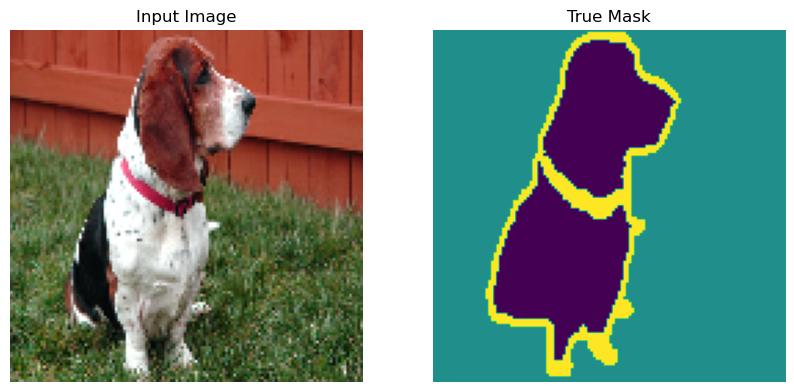

In [40]:
samples = next(iter(train_ds))
sample_img = (samples[0][0], samples[1][0])
display(sample_img)

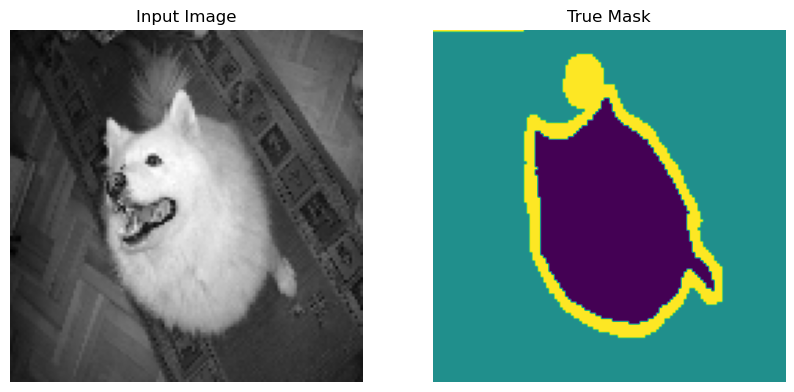

In [39]:
samples = next(iter(val_ds))
sample_img = (samples[0][0], samples[1][0])
display(sample_img)